In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
SPINE_COLOR = 'gray'

def format_axes(ax):

    for spine in ['top', 'right']:
        ax.spines[spine].set_visible(False)

    for spine in ['left', 'bottom']:
        ax.spines[spine].set_color(SPINE_COLOR)
        ax.spines[spine].set_linewidth(0.5)

    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')

    for axis in [ax.xaxis, ax.yaxis]:
        axis.set_tick_params(direction='out', color=SPINE_COLOR)

    return ax

In [3]:
one_dim_normal_data = np.random.normal(0, 1, size=10000)


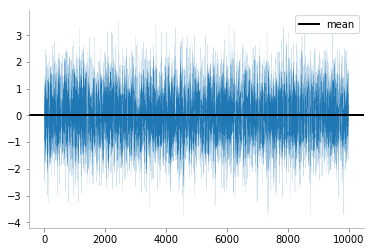

In [4]:
plt.plot(one_dim_normal_data, lw=0.1)
plt.axhline(one_dim_normal_data.mean(), lw=2, color='k', label='mean')
format_axes(plt.gca())
plt.legend()

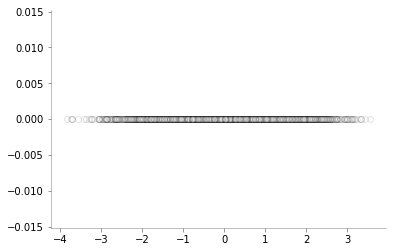

In [5]:
plt.scatter(one_dim_normal_data, np.zeros_like(one_dim_normal_data), alpha=0.1, c='w', edgecolors='k')
format_axes(plt.gca())

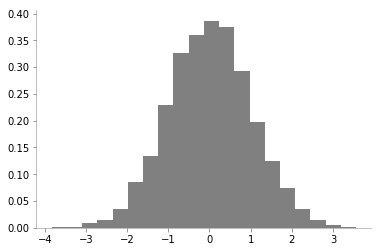

In [6]:
plt.hist(one_dim_normal_data, density=True, bins=20, color='gray')
format_axes(plt.gca())

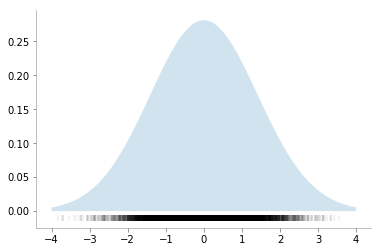

In [7]:
from sklearn.neighbors import KernelDensity

x_d = np.linspace(-4, 4, 100)

# instantiate and fit the KDE model
kde = KernelDensity(bandwidth=1.0, kernel='gaussian')
kde.fit(one_dim_normal_data[:, None])

# score_samples returns the log of the probability density
logprob = kde.score_samples(x_d[:, None])

plt.fill_between(x_d, np.exp(logprob), alpha=0.2)
plt.plot(one_dim_normal_data, np.full_like(one_dim_normal_data, -0.01), '|k', markeredgewidth=0.1)
format_axes(plt.gca())

### Plotting a multi-variate Gaussian

In [8]:
data = np.random.multivariate_normal(mean = np.array([0, 0]), cov = np.array([[1, 0.7], [0.7, 1]]), size=(10000, ))

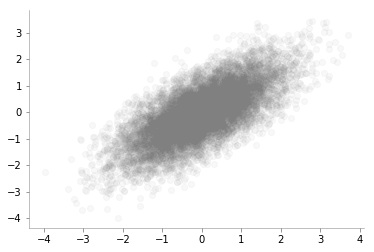

In [9]:
plt.scatter(data[:, 0], data[:, 1], alpha=0.05,c='gray')
format_axes(plt.gca())

In [10]:
import pandas as pd
data_df = pd.DataFrame(data, columns=['x','y'])

/home/nipunbatra-pc/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


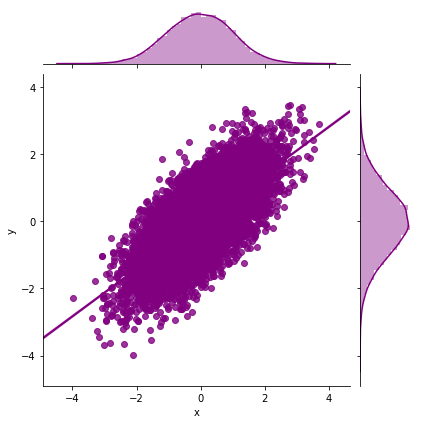

In [11]:
import seaborn as sns
g = sns.jointplot(x= 'x', y='y', data=data_df, kind="reg",color='purple')

In [12]:
def plot_jointplot_2d(corr):
    data = np.random.multivariate_normal(mean = np.array([0, 0]), cov = np.array([[1, corr], [corr, 1]]), size=(10000, ))
    data_df = pd.DataFrame(data, columns=['x','y'])
    g = sns.jointplot(x= 'x', y='y', data=data_df, kind="reg",color='purple')

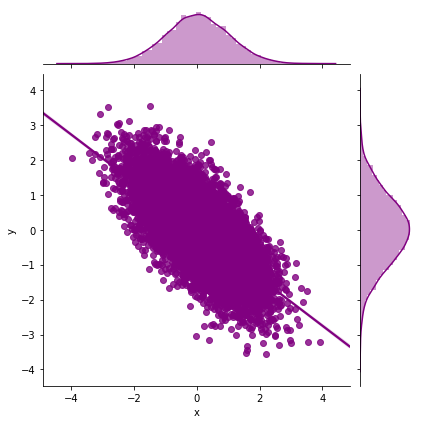

In [13]:
plot_jointplot_2d(-0.7)

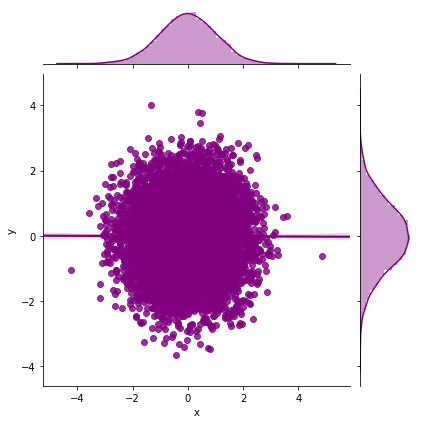

In [14]:
plot_jointplot_2d(0)

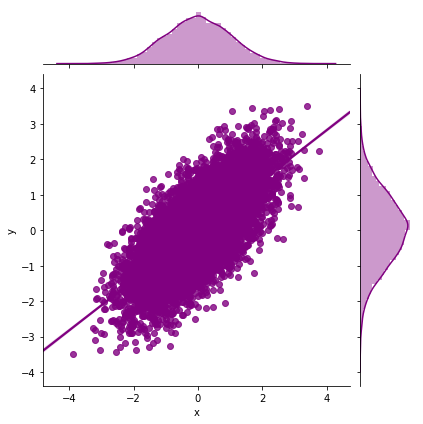

In [15]:
plot_jointplot_2d(0.7)

In [16]:
from scipy.stats import multivariate_normal
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm


def make_pdf_2d_gaussian(mu, sigma):
    N = 60
    X = np.linspace(-3, 3, N)
    Y = np.linspace(-3, 4, N)
    X, Y = np.meshgrid(X, Y)

    # Pack X and Y into a single 3-dimensional array
    pos = np.empty(X.shape + (2,))
    pos[:, :, 0] = X
    pos[:, :, 1] = Y

    F = multivariate_normal(mu, sigma)
    Z = F.pdf(pos)



    # Create a surface plot and projected filled contour plot under it.
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.plot_surface(X, Y, Z, rstride=3, cstride=3, linewidth=1, antialiased=True,
                    cmap=cm.Purples)
    
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("PDF")

    cset = ax.contourf(X, Y, Z, zdir='z', offset=-0.15, cmap=cm.Purples)

    # Adjust the limits, ticks and view angle
    ax.set_zlim(-0.15,0.25)
    ax.set_zticks(np.linspace(0,0.2,5))
    ax.view_init(27, -15)
    ax.set_title(f'Mean = {mu}\n Sigma = {sigma}')

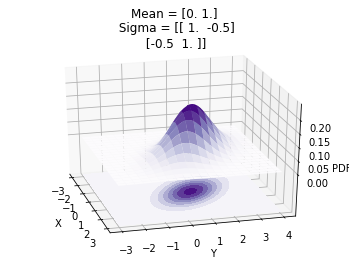

In [17]:
# Mean vector and covariance matrix
mu = np.array([0., 1.])
sigma = np.array([[ 1. , -0.5], [-0.5,  1]])

make_pdf_2d_gaussian(mu, sigma)

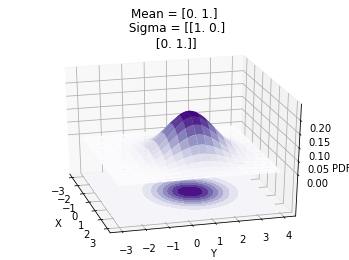

In [18]:
# Mean vector and covariance matrix
mu = np.array([0., 1.])
sigma = np.array([[ 1. , 0], [0,  1]])

make_pdf_2d_gaussian(mu, sigma)

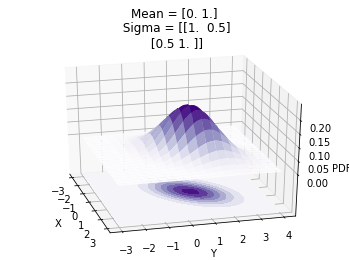

In [19]:
# Mean vector and covariance matrix
mu = np.array([0., 1.])
sigma = np.array([[ 1. , 0.5], [0.5,  1.]])

make_pdf_2d_gaussian(mu, sigma)

In [22]:
def plot_2d_contour_pdf(mu, sigma):
    X = np.linspace(-3, 3, 60)
    Y = np.linspace(-3, 4, 60)
    X, Y = np.meshgrid(X, Y)

    # Pack X and Y into a single 3-dimensional array
    pos = np.empty(X.shape + (2,))
    pos[:, :, 0] = X
    pos[:, :, 1] = Y

    F = multivariate_normal(mu, sigma)
    Z = F.pdf(pos)

    
    plt.title(f'Mean = {mu}\n Sigma = {sigma}')
    plt.contourf(X, Y, Z, zdir='z', offset=-0.15, cmap=cm.Purples)
    plt.colorbar()
    format_axes(plt.gca())

/home/nipunbatra-pc/anaconda3/lib/python3.7/site-packages/matplotlib/contour.py:1000: UserWarning: The following kwargs were not used by contour: 'zdir', 'offset'
  s)


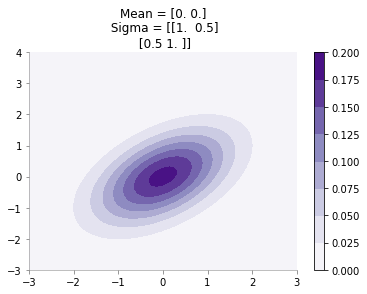

In [23]:
mu = np.array([0., 0.])
sigma = np.array([[ 1. , 0.5], [0.5,  1.]])
plot_2d_contour_pdf(mu, sigma)

/home/nipunbatra-pc/anaconda3/lib/python3.7/site-packages/matplotlib/contour.py:1000: UserWarning: The following kwargs were not used by contour: 'zdir', 'offset'
  s)


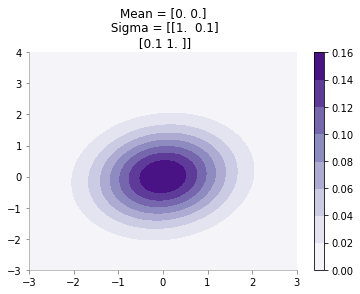

In [24]:
mu = np.array([0., 0.])
sigma = np.array([[ 1. , 0.1], [0.1,  1.]])
plot_2d_contour_pdf(mu, sigma)

### Sample from 2d gaussian and visualise it on XY plane

In [27]:
def plot_2d_contour_pdf_dimensions(mu, sigma, random_num):
    fig, ax  = plt.subplots(ncols=3, figsize=(12, 4))

    X = np.linspace(-3, 3, 60)
    Y = np.linspace(-3, 3, 60)
    X, Y = np.meshgrid(X, Y)

    # Pack X and Y into a single 3-dimensional array
    pos = np.empty(X.shape + (2,))
    pos[:, :, 0] = X
    pos[:, :, 1] = Y

    F = multivariate_normal(mu, sigma)
    Z = F.pdf(pos)
    random_point = F.rvs(random_state=random_num)
    
    sns.heatmap(sigma, ax=ax[0], annot=True)
    ax[1].contour(X, Y, Z, cmap=cm.Purples)
    ax[1].scatter(random_point[0], random_point[1], color='k',s=100)
    ax[1].set_xlabel(r"$X_1$")
    ax[1].set_ylabel(r"$X_2$")
    
    data_array = pd.Series(random_point, index=['X1','X2'])
    data_array.plot(ax=ax[2], kind='line', marker='o',color='k')
    plt.xticks(np.arange(len(data_array.index)), data_array.index.values)
    ax[2].set_ylim(-3, 3)
    format_axes(ax[0])
    format_axes(ax[1])
    format_axes(ax[2])
    ax[0].set_title("Covariance Matrix")
    ax[1].set_title("Contour of pdf")
    ax[2].set_title("Visualising the point")
    plt.suptitle(f"Random state = {random_num}", y=1.1)
    plt.tight_layout()
    import os
    if not os.path.exists("images"):
        os.makedirs("images")
    if not os.path.exists(f"images/{sigma[0, 1]}"):
        os.makedirs(f"images/{sigma[0, 1]}")
    plt.savefig(f"images/{sigma[0, 1]}/{random_num}.jpg", bbox_inches="tight")
    plt.close()

In [28]:
for i in range(20):
    plot_2d_contour_pdf_dimensions( mu, np.array([[ 1. , 0.1], [0.1,  1.]]), i)

In [29]:
!convert -delay 20 -loop 0 images/0.1/*.jpg sigma-0-1.gif

![](sigma-0-1.gif)

In [30]:
for i in range(20):
    plot_2d_contour_pdf_dimensions( mu, np.array([[ 1. , 0.7], [0.7,  1.]]), i)

In [31]:
!convert -delay 20 -loop 0 images/0.7/*.jpg sigma-0-7.gif

![](sigma-0-7.gif)

### Conditional Bivariate Distribution

$$
\begin{pmatrix}
 X_1 \\
 X_2
\end{pmatrix}  \sim \mathcal{N} \left( \begin{pmatrix}
 0 \\
 0
\end{pmatrix} , \begin{pmatrix}
 1 & \rho \\
 \rho & 1
\end{pmatrix} \right)
$$

The conditional expectation of $X_2$ given $X_1$ is: $\operatorname{E}(X_2 \mid X_1=x_1)= \rho x_1 $

and the conditional variance is: $\operatorname{var}(X_2 \mid X_1 = x_1) = 1-\rho^2$ 

Let us fix $X_1 = 1$

In [32]:
def plot_2d_contour_pdf_dimensions_fixed_x1(sigma, random_num, x1 = 1):
    mu = np.zeros(2)
    fig, ax  = plt.subplots(ncols=3, figsize=(12, 4))

    X = np.linspace(-3, 3, 60)
    Y = np.linspace(-3, 3, 60)
    X, Y = np.meshgrid(X, Y)

    # Pack X and Y into a single 3-dimensional array
    pos = np.empty(X.shape + (2,))
    pos[:, :, 0] = X
    pos[:, :, 1] = Y

    F = multivariate_normal(mu, sigma)
    Z = F.pdf(pos)
    
    rho = sigma[0, 1]
    F_cond_x1 = multivariate_normal(rho*x1, 1-rho**2)
    random_point_x2 = F_cond_x1.rvs(random_state=random_num)
    sns.heatmap(sigma, ax=ax[0], annot=True)
    ax[1].contour(X, Y, Z, cmap=cm.Purples)
    ax[1].scatter(x1, random_point_x2, color='k',s=100)
    ax[1].set_xlabel(r"$X_1$")
    ax[1].set_ylabel(r"$X_2$")
    
    data_array = pd.Series([x1, random_point_x2], index=['X1','X2'])
    data_array.plot(ax=ax[2], kind='line', color='k')
    ax[2].scatter(x=0, y=x1, color='red', s=100)
    ax[2].scatter(x=1, y=random_point_x2, color='k', s=100)
    

    plt.xticks(np.arange(len(data_array.index)), data_array.index.values)
    ax[2].set_ylim(-3, 3)
    format_axes(ax[0])
    format_axes(ax[1])
    format_axes(ax[2])
    ax[0].set_title("Covariance Matrix")
    ax[1].set_title("Contour of pdf")
    ax[2].set_title("Visualising the point")
    plt.suptitle(f"Random state = {random_num}", y=1.1)
    plt.tight_layout()
    import os
    if not os.path.exists("images/conditional/"):
        os.makedirs("images/conditional/")
    if not os.path.exists(f"images/conditional/{sigma[0, 1]}"):
        os.makedirs(f"images/conditional/{sigma[0, 1]}")
    plt.savefig(f"images/conditional/{sigma[0, 1]}/{random_num}.jpg", bbox_inches="tight")
    plt.close()

In [33]:
for i in range(20):
    plot_2d_contour_pdf_dimensions_fixed_x1(np.array([[ 1. , 0.1], [0.1,  1.]]), i)

In [34]:
!convert -delay 20 -loop 0 images/conditional/0.1/*.jpg conditional-sigma-0-1.gif

![](conditional-sigma-0-1.gif)

In [35]:
for i in range(20):
    plot_2d_contour_pdf_dimensions_fixed_x1(np.array([[ 1. , 0.7], [0.7,  1.]]), i)

In [36]:
!convert -delay 20 -loop 0 images/conditional/0.7/*.jpg conditional-sigma-0-7.gif

![](conditional-sigma-0-7.gif)

#### Visualising the same procedure for 5 dimensional Gaussian

In [38]:
covariance_5d = np.array([[1, 0.9, 0.8, 0.6, 0.4],
                          [0.9, 1, 0.9, 0.8, 0.6],
                          [0.8, 0.9, 1, 0.9, 0.8],
                          [0.6, 0.8, 0.9, 1, 0.9],
                          [0.4, 0.6, 0.8, 0.9, 1]])

In [39]:
def plot_5d_contour_pdf_dimensions(cov, random_num):
    fig, ax  = plt.subplots(ncols=6, figsize=(18, 4))

    X = np.linspace(-3, 3, 60)
    #Y = np.linspace(-3, 3, 60)
    X, Y = np.meshgrid(X, Y)

    # Pack X and Y into a single 3-dimensional array
    pos = np.empty(X.shape + (2,))
    pos[:, :, 0] = X
    pos[:, :, 1] = Y

    mu = np.zeros(5)
    F = multivariate_normal(mu, cov)
    Z = F.pdf(pos)
    random_point = F.rvs(random_state=random_num)
    
    sns.heatmap(sigma, ax=ax[0], annot=True)
    
    for dim in range(1, 5):
        ax[1+dim].contour(X, Y, Z, cmap=cm.Purples)
        ax[1+dim].scatter(random_point[0], random_point[dim], color='k',s=100)
        ax[1+dim].set_xlabel(r"$X_1$")
        ax[1+dim].set_ylabel(r"$X_{1+dim}$")
    
    data_array = pd.Series(random_point, index=['X1','X2','X3','X4', 'X5'])
    data_array.plot(ax=ax[5], kind='line', marker='o',color='k')
    plt.xticks(np.arange(len(data_array.index)), data_array.index.values)
    ax[5].set_ylim(-3, 3)
    for i in range(6):
        format_axes(ax[i])
    
    ax[0].set_title("Covariance Matrix")
    ax[1].set_title("Contour of pdf")
    ax[-1].set_title("Visualising the point")
    plt.suptitle(f"Random state = {random_num}", y=1.1)
    plt.tight_layout()
    #import os
    #if not os.path.exists("images"):
    #    os.makedirs("images")
    #if not os.path.exists(f"images/{sigma[0, 1]}"):
    #    os.makedirs(f"images/{sigma[0, 1]}")
    #plt.savefig(f"images/{sigma[0, 1]}/{random_num}.jpg", bbox_inches="tight")
    #plt.close()

ValueError: operands could not be broadcast together with shapes (60,60,2) (5,) 

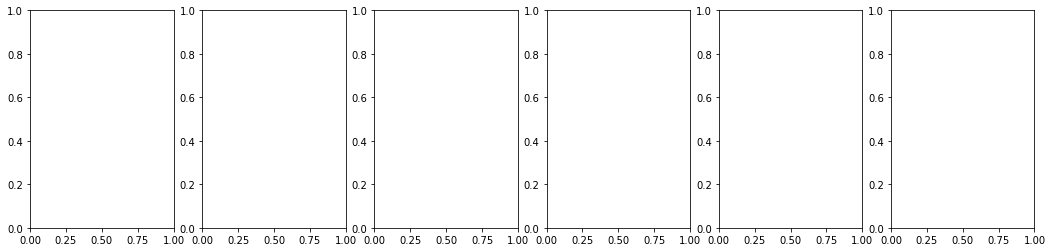

In [41]:
plot_5d_contour_pdf_dimensions(covariance_5d, 1)